In [1]:
!pip install pyreadr
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from linearmodels.panel import PanelOLS, FirstDifferenceOLS, compare, RandomEffects


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.5/437.5 kB 1.9 MB/s eta 0:00:0000:0100:01


In [2]:
path_to_file = 'BaseCom9Nov23.RData'
result = pyreadr.read_r(path_to_file)
df = result["com"]

In [3]:
# Pretraitement des donnees
data_pannels = pd.read_pickle("data_pannels.pkl")
data_pannels.columns
print(df.columns)
df.rename(columns={'date': 'Date'}, inplace=True)
df['idEntreprise'] = df['idEntreprise'].astype(int)
data_pannels['Date'] = pd.to_datetime(data_pannels['Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m') 
data_pannels_finance = pd.merge(data_pannels, df[["idEntreprise","Date","ret","mv"]], on=['idEntreprise', 'Date'], how='left')
data_pannels_finance.sort_values(by=['idEntreprise', 'Date'], inplace=True)
data_pannels_finance.dropna(subset=['ret', 'score_comm', "mv"], inplace=True)
data_pannels_finance['ESG'] = data_pannels_finance['ESG'].str.replace(',', '.').astype(float)
data_pannels_finance['Date'] = pd.to_datetime(data_pannels_finance['Date'])

# Final dataset
data_pannels_finance

Index(['idEntreprise', 'date', 'com', 'y', 'm', 'my', 'ISIN', 'Company',
       'Sect', 'Country', 'Zone', 'fcomp', 'fcomn', 'esge', 'esge1', 'esge2',
       'esge3', 'con', 'con1', 'con2', 'con3', 'fcon1', 'fcon2', 'fcon3',
       'comb', 'CUSIP', 'ret', 'beta12', 'mv', 'bm', 'de_ratio', 'roe'],
      dtype='object')


,idEntreprise,Date,score_comm,ESG,PFL,Diff_z,Controverse,GICS industry group,GICS sub-industry,ret,mv
0,1,2009-01-01,-0.015203,60.866464,100.000000,5.475597,29.837788,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,-0.176736,1.072735e+08
1,1,2009-02-01,-0.014819,61.046910,100.000000,5.339223,23.870230,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,-0.133745,8.303427e+07
2,1,2009-03-01,-0.009638,61.223748,100.000000,5.534291,19.096184,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,0.106417,9.186200e+07
3,1,2009-04-01,-0.019162,60.841493,100.000000,5.639993,26.388059,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,-0.019090,9.010839e+07
4,1,2009-05-01,-0.019016,60.590206,100.000000,5.892612,43.332669,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,0.148952,1.025018e+08
...,...,...,...,...,...,...,...,...,...,...,...
15987,8984,2022-08-01,-0.124924,65.950223,83.333333,-0.182129,0.000000,Materials,Specialty Chemicals,0.015759,3.985769e+06
15988,8984,2022-09-01,-0.127122,65.814552,83.333333,-0.185574,0.000000,Materials,Specialty Chemicals,-0.303274,2.755391e+06
15989,8984,2022-10-01,-0.125377,65.681594,83.333333,-0.185418,0.000000,Materials,Specialty Chemicals,0.138284,3.136417e+06
15990,8984,2022-11-01,-0.125955,66.662407,83.333333,-0.186469,0.000000,Materials,Specialty Chemicals,0.003479,3.147572e+06


In [4]:
data_pannels_finance['idEntreprise'].unique() # = 37, pas terrible mais on fera
                                              # avec, c'est juste pour la demarche

array([   1,    4,   32,   48,   51,  106,  107,  158,  159,  162,  163,
        173,  176,  257,  268,  269,  274,  289,  359,  386,  412,  417,
        467,  473,  823,  921, 1057, 1190, 1671, 1881, 2052, 6635, 6640,
       6652, 6653, 6654, 8984])

Descriptive Statistics:
                ret   score_comm            mv
count  6157.000000  6157.000000  6.157000e+03
mean      0.014033    -0.152293  9.643310e+07
std       0.153793     0.353548  1.761731e+08
min      -0.726316   -16.551159  7.539167e+04
25%      -0.034023    -0.318903  1.553879e+07
50%       0.012327    -0.170481  4.599180e+07
75%       0.056195    -0.049789  1.286296e+08
max       8.798206     2.061700  2.525084e+09


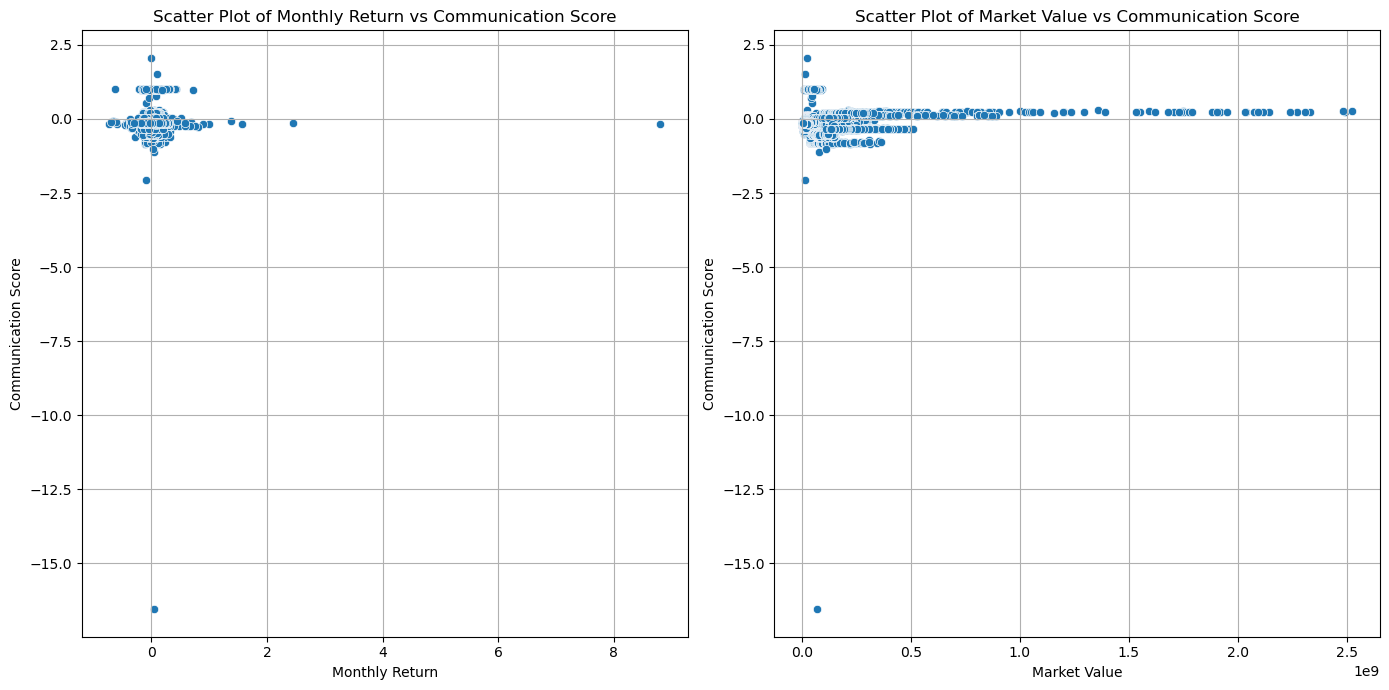

In [5]:
# Calculate descriptive statistics for 'mv', 'ret' and 'score_comm'
descriptive_stats = data_pannels_finance[['ret', 'score_comm', "mv"]].describe()
print("Descriptive Statistics:\n", descriptive_stats)

# Visualization
plt.figure(figsize=(14, 7))

# Scatter plot to explore the relationship between 'mv' and 'score_comm'
plt.subplot(1,2,1)
sns.scatterplot(x='ret', y='score_comm', data=data_pannels_finance)
plt.title('Scatter Plot of Monthly Return vs Communication Score')
plt.xlabel('Monthly Return')
plt.ylabel('Communication Score')
plt.grid(True)

# Scatter plot to explore the relationship between 'mv' and 'score_comm'
plt.subplot(1,2,2)
sns.scatterplot(x='mv', y='score_comm', data=data_pannels_finance)
plt.title('Scatter Plot of Market Value vs Communication Score')
plt.xlabel('Market Value')
plt.ylabel('Communication Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
### Est-ce que le monthly return du mois t-1 a un impact sur le score de communication au mois t ?


data_pannels_finance.set_index(['idEntreprise', 'Date'], inplace=True)

# Calculate the sector average lagged controversy score
data_pannels_finance['Sector_Con_lag1'] = data_pannels_finance.groupby(['GICS industry group', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Generate lagged variables for controversy and market value mv
data_pannels_finance['Con_lag1'] = data_pannels_finance.groupby(level=0)['Controverse'].shift(1)
data_pannels_finance['ret_lag1'] = data_pannels_finance.groupby(level=0)['ret'].shift(1)

# Define exogenous variables including the new sector-based instrument
exog_vars = ['Con_lag1', 'Sector_Con_lag1', 'ret_lag1']

# First stage: Regression of Controversy on lagged controversy and sector average controversy
mod = PanelOLS(dependent=data_pannels_finance['Controverse'], exog=data_pannels_finance[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
data_pannels_finance['Con_star_fix'] = res.fitted_values

# Second stage: Regression of PFL on instrumented Con_star_fix
second_stage = PanelOLS(dependent=data_pannels_finance['PFL'], exog=data_pannels_finance[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
data_pannels_finance['Rep_2SLS'] = res_second_stage.fitted_values
data_pannels_finance['epsilon_hat'] = res_second_stage.resids

# Calculate the proxy for environmental communication flow
data_pannels_finance['phi_hat'] = data_pannels_finance.groupby(level=0)['epsilon_hat'].diff()

# Generate lagged variables for ESG
data_pannels_finance['ESG_lag'] = data_pannels_finance.groupby(level=0)['ESG'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star using the lagged ESG as an instrument
first_stage_esg = PanelOLS(dependent=data_pannels_finance['ESG'], exog=data_pannels_finance[['ESG_lag']], entity_effects=True, time_effects=True)
res_first_stage_esg = first_stage_esg.fit()
data_pannels_finance['ESG_star'] = res_first_stage_esg.fitted_values
data_pannels_finance['ESG_star_shift'] = data_pannels_finance['ESG_star'].shift(1)

data_pannels_finance['Delta_phi_hat'] = data_pannels_finance.groupby('idEntreprise')['phi_hat'].diff()
data_pannels_finance['Delta_ESG_star_shift'] = data_pannels_finance.groupby('idEntreprise')['ESG_star_shift'].diff()

second_stage_phi = PanelOLS(dependent=data_pannels_finance['Delta_phi_hat'], exog=data_pannels_finance[['Delta_ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi = second_stage_phi.fit()

print(res_second_stage_phi)

/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Delta_phi_hat   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0500
No. Observations:                4726   R-squared (Within):               0.0002
Date:                Fri, May 03 2024   R-squared (Overall):              0.0002
Time:                        07:53:26   Log-likelihood                -1.302e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.1693
Entities:                          29   P-value                           0.2796
Avg Obs:                       162.97   Distribution:                  F(1,4696)
Min Obs:                       106.00                                           
Max Obs:                       165.00   F-statistic (robust):             1.1693
                            

/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [7]:
### Est-ce que le monthly return du mois t-1 a un impact sur le score de communication au mois t ?

# Calculate the sector average lagged controversy score
data_pannels_finance['Sector_Con_lag1'] = data_pannels_finance.groupby(['GICS industry group', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Generate lagged variables for controversy and market value mv
data_pannels_finance['Con_lag1'] = data_pannels_finance.groupby(level=0)['Controverse'].shift(1)
data_pannels_finance['ret_lag1'] = data_pannels_finance.groupby(level=0)['ret'].shift(1)

# Define exogenous variables including the new sector-based instrument
exog_vars = ['Con_lag1', 'Sector_Con_lag1']

# First stage: Regression of Controversy on lagged controversy and sector average controversy
mod = PanelOLS(dependent=data_pannels_finance['Controverse'], exog=data_pannels_finance[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
data_pannels_finance['Con_star_fix'] = res.fitted_values

# Second stage: Regression of PFL on instrumented Con_star_fix
second_stage = PanelOLS(dependent=data_pannels_finance['PFL'], exog=data_pannels_finance[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
data_pannels_finance['Rep_2SLS'] = res_second_stage.fitted_values
data_pannels_finance['epsilon_hat'] = res_second_stage.resids

# Calculate the proxy for environmental communication flow
data_pannels_finance['phi_hat'] = data_pannels_finance.groupby(level=0)['epsilon_hat'].diff()

# Generate lagged variables for ESG
data_pannels_finance['ESG_lag'] = data_pannels_finance.groupby(level=0)['ESG'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star using the lagged ESG as an instrument
first_stage_esg = PanelOLS(dependent=data_pannels_finance['ESG'], exog=data_pannels_finance[['ESG_lag']], entity_effects=True, time_effects=True)
res_first_stage_esg = first_stage_esg.fit()
data_pannels_finance['ESG_star'] = res_first_stage_esg.fitted_values
data_pannels_finance['ESG_star_shift'] = data_pannels_finance['ESG_star'].shift(1)

data_pannels_finance['Delta_phi_hat'] = data_pannels_finance.groupby('idEntreprise')['phi_hat'].diff()
data_pannels_finance['Delta_ESG_star_shift'] = data_pannels_finance.groupby('idEntreprise')['ESG_star_shift'].diff()
data_pannels_finance['Delta_ret_lag1'] = data_pannels_finance.groupby(level=0)['ret'].diff()


second_stage_phi = PanelOLS(dependent=data_pannels_finance['Delta_phi_hat'], exog=data_pannels_finance[['Delta_ESG_star_shift','Delta_ret_lag1']], entity_effects=True, time_effects=False)
res_second_stage_phi = second_stage_phi.fit()

print(res_second_stage_phi)

/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Delta_phi_hat   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.0505
No. Observations:                4726   R-squared (Within):               0.0003
Date:                Fri, May 03 2024   R-squared (Overall):              0.0003
Time:                        07:53:32   Log-likelihood                -1.302e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.6904
Entities:                          29   P-value                           0.5014
Avg Obs:                       162.97   Distribution:                  F(2,4695)
Min Obs:                       106.00                                           
Max Obs:                       165.00   F-statistic (robust):             0.6904
                            

In [8]:
### Est-ce que le monthly return du mois t-1 a un impact sur le score de communication au mois t ?

# Calculate the sector average lagged controversy score
data_pannels_finance['Sector_Con_lag1'] = data_pannels_finance.groupby(['GICS industry group', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Generate lagged variables for controversy and market value mv
data_pannels_finance['Con_lag1'] = data_pannels_finance.groupby(level=0)['Controverse'].shift(1)
data_pannels_finance['ret_lag1'] = data_pannels_finance.groupby(level=0)['ret'].shift(1)

# Define exogenous variables including the new sector-based instrument
exog_vars = ['Con_lag1', 'Sector_Con_lag1']

# First stage: Regression of Controversy on lagged controversy and sector average controversy
mod = PanelOLS(dependent=data_pannels_finance['Controverse'], exog=data_pannels_finance[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
data_pannels_finance['Con_star_fix'] = res.fitted_values

# Second stage: Regression of PFL on instrumented Con_star_fix
second_stage = PanelOLS(dependent=data_pannels_finance['PFL'], exog=data_pannels_finance[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
data_pannels_finance['Rep_2SLS'] = res_second_stage.fitted_values
data_pannels_finance['epsilon_hat'] = res_second_stage.resids

# Calculate the proxy for environmental communication flow
data_pannels_finance['phi_hat'] = data_pannels_finance.groupby(level=0)['epsilon_hat'].diff()

# Generate lagged variables for ESG
data_pannels_finance['ESG_lag'] = data_pannels_finance.groupby(level=0)['ESG'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star using the lagged ESG as an instrument
first_stage_esg = PanelOLS(dependent=data_pannels_finance['ESG'], exog=data_pannels_finance[['ESG_lag','ret_lag1']], entity_effects=True, time_effects=True)
res_first_stage_esg = first_stage_esg.fit()
data_pannels_finance['ESG_star'] = res_first_stage_esg.fitted_values
data_pannels_finance['ESG_star_shift'] = data_pannels_finance['ESG_star'].shift(1)

data_pannels_finance['Delta_phi_hat'] = data_pannels_finance.groupby('idEntreprise')['phi_hat'].diff()
data_pannels_finance['Delta_ESG_star_shift'] = data_pannels_finance.groupby('idEntreprise')['ESG_star_shift'].diff()

second_stage_phi = PanelOLS(dependent=data_pannels_finance['Delta_phi_hat'], exog=data_pannels_finance[['Delta_ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi = second_stage_phi.fit()

print(res_second_stage_phi)

/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/mamba/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Delta_phi_hat   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.0502
No. Observations:                4726   R-squared (Within):               0.0003
Date:                Fri, May 03 2024   R-squared (Overall):              0.0002
Time:                        07:53:36   Log-likelihood                -1.302e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.1790
Entities:                          29   P-value                           0.2776
Avg Obs:                       162.97   Distribution:                  F(1,4696)
Min Obs:                       106.00                                           
Max Obs:                       165.00   F-statistic (robust):             1.1790
                            

In [9]:
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Controverse   R-squared:                        0.8206
Estimator:                   PanelOLS   R-squared (Between):              0.9850
No. Observations:                4784   R-squared (Within):               0.8439
Date:                Fri, May 03 2024   R-squared (Overall):              0.9495
Time:                        07:53:35   Log-likelihood                -1.659e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.049e+04
Entities:                          29   P-value                           0.0000
Avg Obs:                       164.97   Distribution:                  F(2,4587)
Min Obs:                       108.00                                           
Max Obs:                       167.00   F-statistic (robust):          1.049e+04
                            

In [10]:
### Est-ce que le score de communication au mois t-1 a un impact sur la market-value au mois t ?

data_pannels_finance.set_index(['idEntreprise', 'Date'], inplace=True)

# Calculate the sector average lagged controversy score
data_pannels_finance['Sector_Con_lag1'] = data_pannels_finance.groupby(['GICS industry group', pd.Grouper(level='Date')])['Controverse'].transform(lambda x: x.shift(1).mean())

# Generate lagged variables for controversy and market value mv
data_pannels_finance['Con_lag1'] = data_pannels_finance.groupby(level=0)['Controverse'].shift(1)
data_pannels_finance['score_comm_lag1'] = data_pannels_finance.groupby(level=0)['score_comm'].shift(1)

# Define exogenous variables including all the instruments
exog_vars = ['Con_lag1', 'Sector_Con_lag1', 'ret_lag1']

# First stage: Regression of Controversy on lagged controversy and sector average controversy
mod = PanelOLS(dependent=data_pannels_finance['Controverse'], exog=data_pannels_finance[exog_vars], entity_effects=True, time_effects=True)
res = mod.fit()
data_pannels_finance['Con_star_fix'] = res.fitted_values

# Second stage: Regression of PFL on instrumented Con_star_fix
second_stage = PanelOLS(dependent=data_pannels_finance['PFL'], exog=data_pannels_finance[['Con_star_fix']], entity_effects=True, time_effects=True)
res_second_stage = second_stage.fit()
data_pannels_finance['Rep_2SLS'] = res_second_stage.fitted_values
data_pannels_finance['epsilon_hat'] = res_second_stage.resids

# Calculate the proxy for environmental communication flow
data_pannels_finance['phi_hat'] = data_pannels_finance.groupby(level=0)['epsilon_hat'].diff()

# Generate lagged variables for ESG
data_pannels_finance['ESG_lag'] = data_pannels_finance.groupby(level=0)['ESG'].shift(1)

# Second stage: Regression of phi_hat on shifted ESG_star using the lagged ESG as an instrument
first_stage_esg = PanelOLS(dependent=data_pannels_finance['ESG'], exog=data_pannels_finance[['ESG_lag']], entity_effects=True, time_effects=True)
res_first_stage_esg = first_stage_esg.fit()
data_pannels_finance['ESG_star'] = res_first_stage_esg.fitted_values
data_pannels_finance['ESG_star_shift'] = data_pannels_finance['ESG_star'].shift(1)

data_pannels_finance['Delta_phi_hat'] = data_pannels_finance.groupby('idEntreprise')['phi_hat'].diff()
data_pannels_finance['Delta_ESG_star_shift'] = data_pannels_finance.groupby('idEntreprise')['ESG_star_shift'].diff()

second_stage_phi = PanelOLS(dependent=data_pannels_finance['Delta_phi_hat'], exog=data_pannels_finance[['Delta_ESG_star_shift']], entity_effects=True, time_effects=False)
res_second_stage_phi = second_stage_phi.fit()

print(res_second_stage_phi)

KeyError: "None of ['idEntreprise', 'Date'] are in the columns"